In [60]:
import duckdb
import pandas as pd
import statsmodels.formula.api as smf
from debugpy.common.util import evaluate
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load design matrix from gold schema

Transformations and preparation done in `dbt` project.

In [78]:
data_dir = '../data/ppp_loan_analysis.duckdb'
with duckdb.connect(data_dir) as conn:
    query = """
        SELECT * EXCLUDE (ppp_loan_amount, total_annual_wages)
        FROM gold.wage_adjusted_ppp_target
    """
    df = conn.execute(query).df()
    
df_clean = df.dropna()
assert len(df) == len(df_clean), 'Design matrix has missing values to remove'
df.head()

,county,state,urbanicity,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,trump_share
0,Maricopa County,Arizona,urban,0.027576,0.827994,0.063833,0.046308,0.031203,0.314097,0.476684
1,Collin County,Texas,urban,0.031156,0.692616,0.108620,0.162953,0.007864,0.155244,0.556180
2,Miami-Dade County,Florida,urban,0.052243,0.790489,0.177317,0.016236,0.003355,0.694297,0.340744
3,Webb County,Texas,urban,0.036737,0.975738,0.007349,0.006159,0.006322,0.953899,0.227520
4,Caldwell County,North Carolina,urban,0.028143,0.915050,0.051571,0.007532,0.007459,0.059067,0.732957


## Evaluate correlations of numerical variables

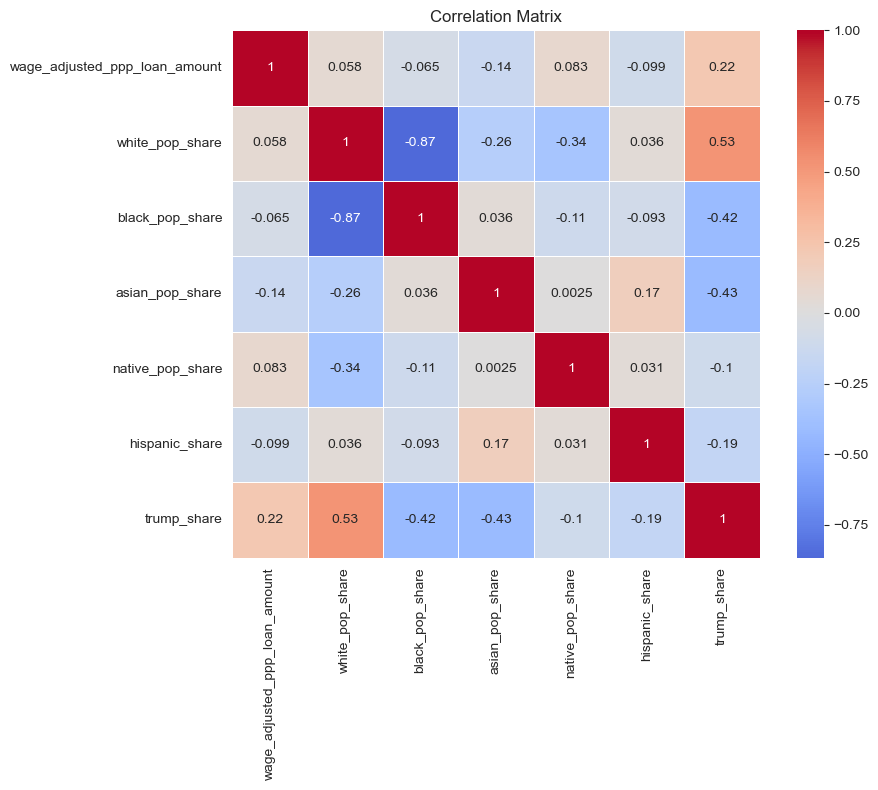

In [79]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Evaluate regression on all features

In [94]:
formula = f"np.log(wage_adjusted_ppp_loan_amount) ~ black_pop_share + white_pop_share + asian_pop_share + hispanic_share + trump_share + C(urbanicity, Treatment(reference='urban'))"

model1 = smf.ols(formula, data=df).fit()
print(model1.summary())

                                      OLS Regression Results                                     
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.301
Model:                                               OLS   Adj. R-squared:                  0.300
Method:                                    Least Squares   F-statistic:                     191.1
Date:                                   Tue, 22 Jul 2025   Prob (F-statistic):          3.78e-236
Time:                                           11:37:37   Log-Likelihood:                -2159.4
No. Observations:                                   3113   AIC:                             4335.
Df Residuals:                                       3105   BIC:                             4383.
Df Model:                                              7                                         
Covariance Type:                               nonrobust                                         
                    

## Model evaluation and quality checks

Evaluate multi-collinearity for potential removal of features and then evaluate model assumptions, in light of high Kurtosis, suggesting that residuals may not follow a normal distribution. 

### Inspect multi-collinearity

In [102]:
def evaluate_vifs(model):
    dataframe = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
    
    # Define the predictor variables
    X = dataframe.select_dtypes(include=[np.number])
    
    # Add a constant to the model (intercept)
    X = add_constant(X)
    
    # Calculate VIF for each feature
    datacamp_vif_data = pd.DataFrame()
    datacamp_vif_data['Feature'] = X.columns
    datacamp_vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(datacamp_vif_data)

evaluate_vifs(model1)

                                                   Feature         VIF
0                                                Intercept  201.601104
1     C(urbanicity, Treatment(reference='urban'))[T.rural]    1.435242
2  C(urbanicity, Treatment(reference='urban'))[T.suburban]    1.371200
3                                          black_pop_share    4.871809
4                                          white_pop_share    5.343987
5                                          asian_pop_share    1.531999
6                                           hispanic_share    1.087422
7                                              trump_share    1.754144


bp_stat: 128.98138782593 | bp_pvalue: 1.025914207978908e-24


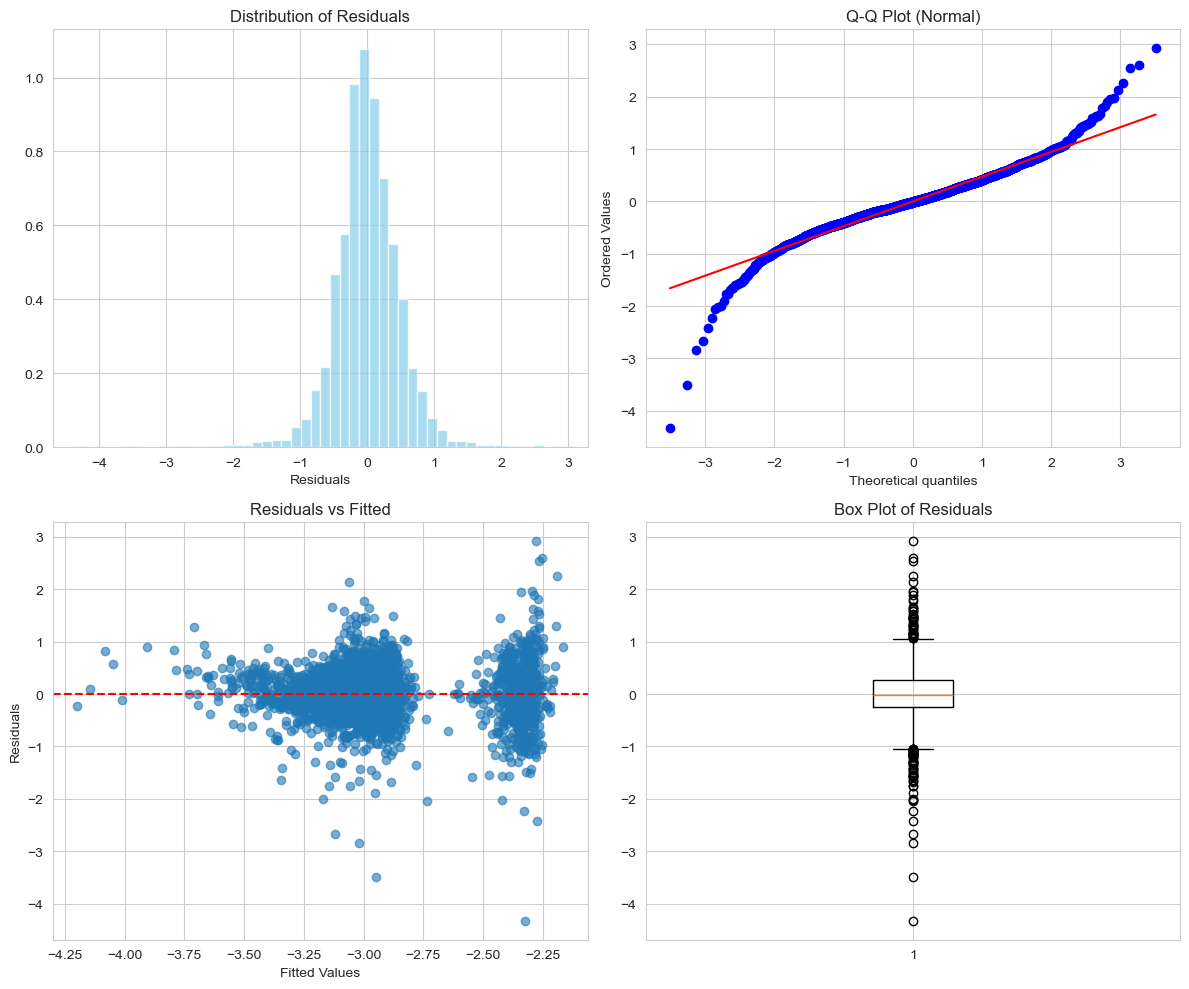

In [106]:
def test_model_assumptions(model):
    # Get residuals from your model
    residuals = model.resid
    
    X_design = model.model.exog
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(model.resid, X_design)
    print(f'bp_stat: {bp_stat} | bp_pvalue: {bp_pvalue}')
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram
    axes[0, 0].hist(residuals, bins=50, density=True, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Residuals')
    axes[0, 0].set_xlabel('Residuals')
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot (Normal)')
    
    # 3. Residuals vs Fitted
    fitted = model.fittedvalues
    axes[1, 0].scatter(fitted, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Fitted')
    
    # 4. Box plot
    axes[1, 1].boxplot(residuals)
    axes[1, 1].set_title('Box Plot of Residuals')
    
    plt.tight_layout()
    plt.show()

test_model_assumptions(model1)

## Model interpretation

R^2 and Adj. R^2 show strong descriptive power, but explore additional features to better capture PPP lending trends.

### VIF
From p-values, feature `black_pop_share` can be removed, reinforced by VIF computation. Kurtosis of ~8.8 indicates heteroscedacity should be checked, to question linear regression assumptions before proceeding with default standard errors.

### Model assumptions
Breusch Pagan p value Q-Q and residuals v. fitted plots show model does not meet linear regression assumptions and that other standard errors should be explored, such as HC3.   

## Revise model from assumptions

In [104]:
fmodel2 = smf.ols("np.log(wage_adjusted_ppp_loan_amount) ~ white_pop_share + asian_pop_share + hispanic_share + trump_share + C(urbanicity, Treatment(reference='urban'))", data=df).fit(cov_type='HC3')
print(model2.summary())

                                      OLS Regression Results                                     
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.301
Model:                                               OLS   Adj. R-squared:                  0.299
Method:                                    Least Squares   F-statistic:                     155.5
Date:                                   Tue, 22 Jul 2025   Prob (F-statistic):          4.64e-173
Time:                                           11:44:25   Log-Likelihood:                -2160.8
No. Observations:                                   3113   AIC:                             4336.
Df Residuals:                                       3106   BIC:                             4378.
Df Model:                                              6                                         
Covariance Type:                                     HC3                                         
                    

### Evaluate new model

                                                   Feature        VIF
0                                                Intercept  39.631770
1     C(urbanicity, Treatment(reference='urban'))[T.rural]   1.408183
2  C(urbanicity, Treatment(reference='urban'))[T.suburban]   1.361560
3                                          white_pop_share   1.428510
4                                          asian_pop_share   1.295304
5                                           hispanic_share   1.081314
6                                              trump_share   1.749567
bp_stat: 130.10062105911533 | bp_pvalue: 1.2241323068311286e-25


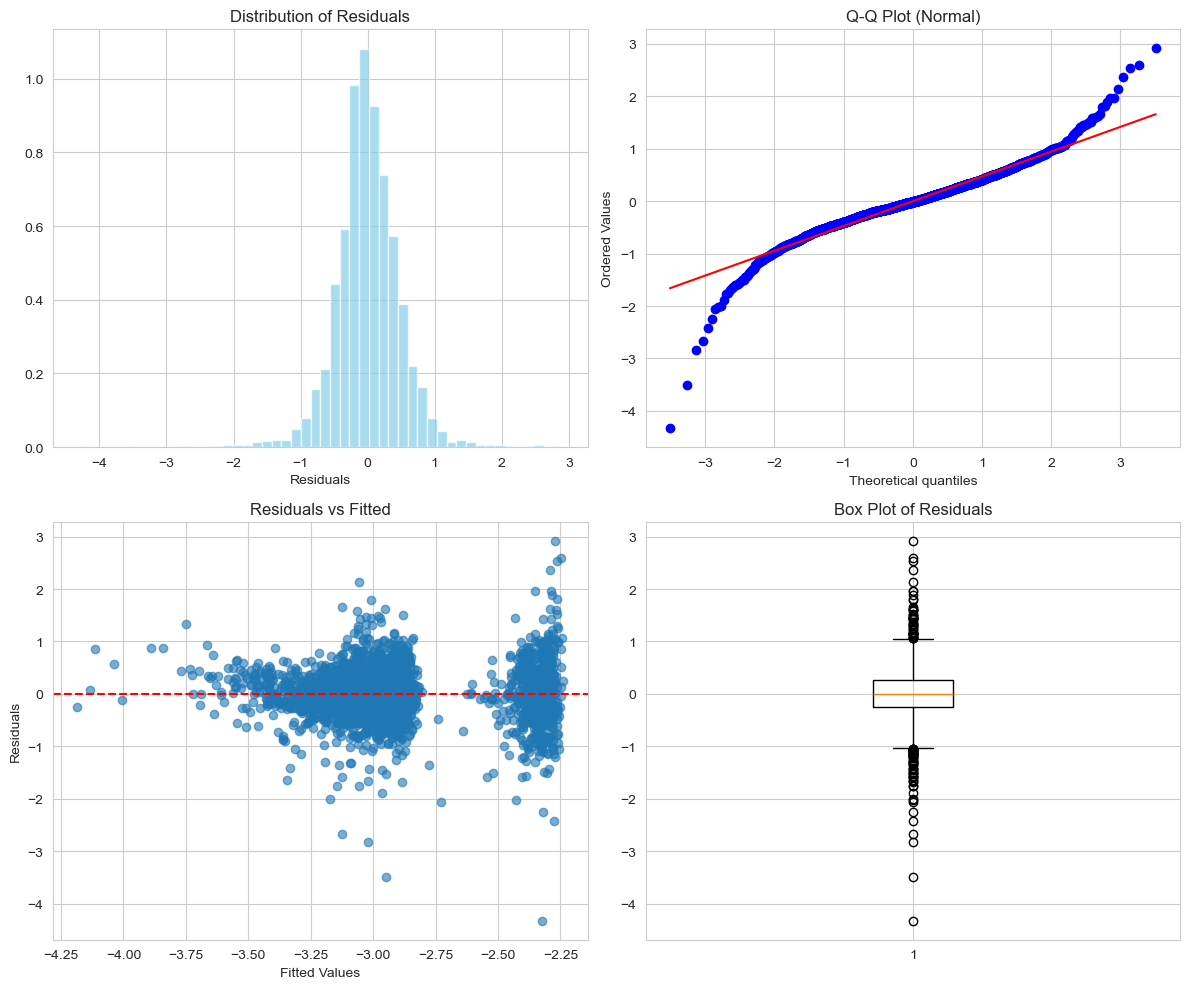

In [107]:
evaluate_vifs(model2)
test_model_assumptions(model2)

In [130]:
df.describe()

,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,trump_share
count,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000
mean,0.066796,0.846676,0.094371,0.015580,0.022155,0.098168,0.632506
std,0.071844,0.159025,0.145048,0.029364,0.065444,0.139227,0.156683
min,0.001292,0.080279,0.000000,0.000000,0.000000,0.006478,0.040875
25%,0.038206,0.798492,0.008935,0.004769,0.004550,0.024580,0.544569
50%,0.050573,0.913466,0.025990,0.007454,0.007599,0.044790,0.663167
75%,0.072449,0.954334,0.110367,0.014363,0.015044,0.101944,0.748934
max,1.901605,0.990350,0.865932,0.433623,0.867643,0.963533,0.945848


In [129]:
residuals = model2.resid
residuals_standardized = (residuals - residuals.mean()) / residuals.std()
extremes = np.abs(residuals_standardized) > 2

,county,state,urbanicity,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,trump_share
125,Tishomingo County,Mississippi,rural,0.032458,0.958572,0.025435,0.002115,0.004282,0.034308,0.856051
173,Cherry County,Nebraska,suburban,0.170432,0.890666,0.004570,0.005449,0.068378,0.032695,0.841244
174,McKenzie County,North Dakota,rural,0.036566,0.842186,0.021366,0.009784,0.092718,0.097045,0.785531
181,Unicoi County,Tennessee,urban,0.016774,0.974221,0.005256,0.002572,0.005927,0.054801,0.788186
209,Merrick County,Nebraska,urban,0.142222,0.964152,0.004900,0.009542,0.009155,0.050290,0.772439
...,...,...,...,...,...,...,...,...,...,...
3098,Ferry County,Washington,rural,0.033298,0.761374,0.008129,0.011276,0.169267,0.048250,0.611497
3100,Tyler County,West Virginia,rural,0.023900,0.977185,0.003376,0.005238,0.003259,0.007682,0.819923
3104,Petroleum County,Montana,rural,0.382195,0.965092,0.000000,0.000000,0.012320,0.022587,0.863354
3110,Keweenaw County,Michigan,rural,0.240430,0.972590,0.003781,0.000945,0.003781,0.017013,0.567643
